In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# IMPORTS LIBRARIES NEEDED #######################################################################

import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop, Adam, SGD
from keras import layers
from keras import models

from keras.applications import Xception
from keras.applications.xception import preprocess_input

from keras.callbacks import ModelCheckpoint, EarlyStopping


In [ ]:
# DEFINES SOME PARAMETERS ########################################################################

train_path  = "/content/drive/My Drive/ML/projects/chest_xray/images/train"
test_path   = "/content/drive/My Drive/ML/projects/chest_xray/images/test"
val_path    = "/content/drive/My Drive/ML/projects/chest_xray/images/val"
models_path = "/content/drive/My Drive/ML/projects/chest_xray/cnn_models/"

BATCH_SIZE = 32

IM_HEIGHT = 200
IM_WIDTH = 200

NTRAIN_IMAGES = 5216
NTEST_IMAGES = 624
NVAL_IMAGES = 16

In [0]:
# CREATES DATA GENERATORS FOR READING AND AUGMENTING IMAGES ######################################

# The function ImageDataGenerator augments your image by iterating 
train_datagen = ImageDataGenerator(
                                   preprocessing_function = preprocess_input,
                                   rotation_range = 15,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   rescale = 1./255                           )

test_datagen = ImageDataGenerator(
                                   preprocessing_function = preprocess_input,
                                   rescale = 1./255                           )

train_generator = train_datagen.flow_from_directory(train_path,
                                           target_size = (IM_HEIGHT, IM_WIDTH),
                                           batch_size = BATCH_SIZE,
                                           shuffle = True,
                                           class_mode = 'categorical')

test_generator  = test_datagen.flow_from_directory( test_path,
                                           target_size = (IM_HEIGHT, IM_WIDTH),
                                           batch_size = BATCH_SIZE,
                                           class_mode = 'categorical')

val_generator   = test_datagen.flow_from_directory( val_path,
                                           target_size=(IM_HEIGHT, IM_WIDTH),
                                           batch_size=1,
                                           class_mode='categorical')


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [0]:
# CREATES THE CNN MODEL ##########################################################################

#init = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=1)
input = layers.Input(shape=(IM_HEIGHT,IM_WIDTH,3)) 

conv1 = layers.convolutional.Conv2D( filters=64, kernel_size=(3,3),  
                                     #activity_regularizer=regularizers.l2(0.01), 
                                     #use_bias=True,bias_initializer=init, 
                                     #kernel_initializer=init,
                                     activation = 'relu')(input)
pool1 = layers.MaxPooling2D((2,2))(conv1)
batch1 = layers.BatchNormalization()(pool1)
drop1 = layers.Dropout(0.2)(batch1)

conv2 = layers.convolutional.Conv2D( filters=64, kernel_size=(3,3),  
                                     #activity_regularizer=regularizers.l2(0.01), 
                                     #use_bias=True,bias_initializer=init, 
                                     #kernel_initializer=init,
                                     activation = 'relu')(drop1) 
pool2 = layers.MaxPooling2D((2,2))(conv2)
batch2 = layers.BatchNormalization()(pool2)
drop2 = layers.Dropout(0.2)(batch2)

conv3 = layers.convolutional.Conv2D( filters=128, kernel_size=(3,3),  
                                     #activity_regularizer=regularizers.l2(0.01), 
                                     #use_bias=True,bias_initializer=init, 
                                     #kernel_initializer=init,
                                     activation = 'relu')(drop2)
pool3 = layers.MaxPooling2D((2,2))(conv3)
batch3 = layers.BatchNormalization()(pool3)
drop3 = layers.Dropout(0.2)(batch3)

conv4 = layers.convolutional.Conv2D( filters=128, kernel_size=(3,3),  
                                     #activity_regularizer=regularizers.l2(0.01), 
                                     #use_bias=True,bias_initializer=init, 
                                     #kernel_initializer=init,
                                     activation = 'relu')(drop3) 
pool4 = layers.MaxPooling2D((2,2))(conv4)

conv5 = layers.convolutional.Conv2D( filters=128, kernel_size=(3,3),activation='relu')(pool4)
pool5 = layers.MaxPooling2D((2,2))(conv5)

flat = layers.Flatten()(pool5)

dense1 = layers.Dense( 8, 
                       #use_bias=True, bias_initializer=init, kernel_initializer=init,
                       activation='relu')(flat) 
dense2 = layers.Dense( 1,
                       #use_bias=True, bias_initializer=init, kernel_initializer=init,
                       activation='sigmoid')(dense1)

model = models.Model(inputs=input, outputs=dense2) 
optim = RMSprop(lr=0.0007) 
model.compile(optimizer=optim, loss='binary_crossentropy', metrics=['accuracy'] )

model.summary()

Model: "model_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           (None, 200, 200, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 99, 99, 32)   864         input_29[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 99, 99, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 99, 99, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [0]:
# TRAINS THE MODEL ###############################################################################

# Configures callback function for saving the model when val_acc improves
h5_filepath = models_path + "conv4d2.{epoch:02d}-{val_acc:.3f}.h5"
checkpoint = ModelCheckpoint( h5_filepath, monitor='val_acc', verbose=1, 
                              save_best_only=True, 
                              save_weights_only=False, 
                              mode='auto', 
                              period=1)  # number of epochs between checkpoints

# Configures callback to stop training when val_acc stops improving
# early = EarlyStopping(monitor='val_acc', min_delta=0, patience=3, verbose=1, 
#                       mode='auto')
#callbacks_list = [checkpoint, early]
callbacks_list = [checkpoint]

# Runs training
history = model.fit_generator(train_generator,
                              steps_per_epoch = NTRAIN_IMAGES // BATCH_SIZE,
                              epochs = 50,
                              validation_data = test_generator,
                              validation_steps = NTEST_IMAGES // BATCH_SIZE,
                              #shuffle = True, 
                              callbacks = callbacks_list )

Epoch 1/20
163/163 [==============================] - 228s 1s/step - loss: 0.3660 - acc: 0.8974 - val_loss: 9.9743 - val_acc: 0.3750

Epoch 00001: val_acc improved from -inf to 0.37500, saving model to /content/drive/My Drive/ML/projects/chest_xray/cnn_models/xception.01-0.375.h5
Epoch 2/20
163/163 [==============================] - 197s 1s/step - loss: 0.1770 - acc: 0.9413 - val_loss: 8.2006 - val_acc: 0.4257

Epoch 00002: val_acc improved from 0.37500 to 0.42568, saving model to /content/drive/My Drive/ML/projects/chest_xray/cnn_models/xception.02-0.426.h5
Epoch 3/20
163/163 [==============================] - 197s 1s/step - loss: 0.1533 - acc: 0.9532 - val_loss: 2.4515 - val_acc: 0.8007

Epoch 00003: val_acc improved from 0.42568 to 0.80068, saving model to /content/drive/My Drive/ML/projects/chest_xray/cnn_models/xception.03-0.801.h5
Epoch 4/20
163/163 [==============================] - 198s 1s/step - loss: 0.1159 - acc: 0.9647 - val_loss: 0.8603 - val_acc: 0.8361

Epoch 00004: val_

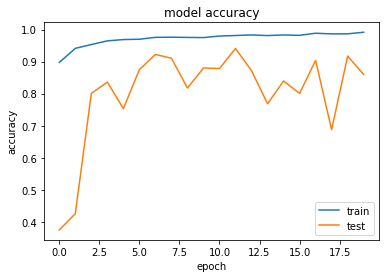

In [0]:
# PLOTS TRAINING RESULTS 

# Plots history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

#from sklearn.metrics import classification_report
#pred = model.predict(test_set)
#print(classification_report(np.argmax(y_valid, axis = 1),np.argmax(pred, axis = 1)))


In [0]:
model_path = "/content/drive/My Drive/ML/projects/chest_xray/cnn_models/cxrays_conv4d2.h5"

model.save_weights(model_path)


In [0]:
scores = model.evaluate_generator(val_generator, verbose=2)

scores

[0.6064742734051833, 0.8125]

In [0]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.grid(b=False)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    

In [0]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(y_valid, axis = 1),np.argmax(pred, axis = 1))
plot_confusion_matrix(cm = cm,
                      normalize    = False,
                      cmap ='Reds',
                      target_names = ['0','1'],
                      title        = "Confusion Matrix")


NameError: ignored